Modelado Predictivo - Ventas Licorera "El Buen Gusto"

Estructura del Modelado:
1. **Preparación de datos**
   - Limpieza y tratamiento de valores faltantes
   - Creación de variables derivadas (features engineering)
-  - División en conjuntos de entrenamiento y prueba

2. **Desarrollo de modelos**
   - Implementar al menos 3 enfoques diferentes:
     - Modelo de series temporales (ARIMA, Prophet, etc.)
     - Modelo de machine learning (Random Forest, XGBoost, etc.)
     - Modelo de regresión múltiple
   - Validación cruzada temporal apropiada

3. **Evaluación y selección**
   - Métricas de evaluación: MAE, RMSE, MAPE
   - Comparación de modelos
   - Análisis de residuales


1. Configuración Inicial

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import (mean_absolute_error, 
                            mean_squared_error, 
                            mean_absolute_percentage_error,
                            r2_score)
from sklearn.model_selection import RandomizedSearchCV
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuración de visualizaciones
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
sns.set_palette("husl")
pd.options.display.float_format = '{:,.2f}'.format


2. Preparación de datos

In [3]:
# Carga de datos
df = pd.read_csv('../data/ventas_licorera.csv', parse_dates=['fecha'])
df = df.sort_values(['fecha', 'sucursal_id']).reset_index(drop=True)

# Verificación inicial
print("Estructura del dataset:")
print(f"- Registros: {df.shape[0]:,}")
print(f"- Columnas: {df.shape[1]}")
print(f"- Rango temporal: {df['fecha'].min().date()} a {df['fecha'].max().date()}")
print(f"- Sucursales: {df['sucursal_id'].nunique()}")
print(f"- Productos únicos: {df['nombre_producto'].nunique()}")

# Muestra inicial
display(df.head(3))

Estructura del dataset:
- Registros: 186,489
- Columnas: 14
- Rango temporal: 2022-01-01 a 2024-12-31
- Sucursales: 15
- Productos únicos: 26


,fecha,sucursal_id,categoria_producto,nombre_producto,precio_unitario,cantidad_vendida,total_venta,dia_semana,mes,promocion_activa,evento_especial,temperatura_promedio,lluvia,zona_sucursal
0,2022-01-01,1,Cerveza,Club Colombia 330ml,3.20,32,102.40,6,1,1,Año_Nuevo,26.50,0,Norte
1,2022-01-01,1,Bebidas_Preparadas,Smirnoff Ice 275ml,4.20,28,117.60,6,1,1,Año_Nuevo,26.50,0,Norte
2,2022-01-01,1,Cerveza,Corona 355ml,5.20,26,135.20,6,1,0,Año_Nuevo,26.50,0,Norte


   2.1 Ingeniería de Características Temporales

In [4]:
# Extracción de características temporales avanzadas
def extract_time_features(df):
    df['año'] = df['fecha'].dt.year
    df['mes'] = df['fecha'].dt.month
    df['dia_mes'] = df['fecha'].dt.day
    df['dia_semana'] = df['fecha'].dt.dayofweek + 1  # 1=Lunes, 7=Domingo
    df['dia_año'] = df['fecha'].dt.dayofyear
    df['semana_año'] = df['fecha'].dt.isocalendar().week
    df['trimestre'] = df['fecha'].dt.quarter
    df['fin_de_semana'] = df['dia_semana'].isin([6, 7]).astype(int)
    df['es_quincena'] = df['dia_mes'].isin([15, 30, 31]).astype(int)
    df['es_inicio_mes'] = (df['dia_mes'] == 1).astype(int)
    return df

df = extract_time_features(df)

# Variables de eventos y clima
df['es_evento'] = (df['evento_especial'] != 'Ninguno').astype(int)
df['lluvia_temperatura'] = df['lluvia'] * df['temperatura_promedio']

# Interacciones relevantes
df['promo_evento'] = df['promocion_activa'] * df['es_evento']
df['finde_evento'] = df['fin_de_semana'] * df['es_evento']


   2.2 Lag Features y Rolling Statistics

In [5]:
# Función para calcular features temporales agrupadas
def add_temporal_features(group):
    # Lags
    group['venta_lag_1d'] = group['total_venta'].shift(1)
    group['venta_lag_7d'] = group['total_venta'].shift(7)
    group['venta_lag_30d'] = group['total_venta'].shift(30)
    
    # Promedios móviles
    group['venta_media_7d'] = group['total_venta'].rolling(7).mean().shift(1)
    group['venta_media_30d'] = group['total_venta'].rolling(30).mean().shift(1)
    
    # Máximos y mínimos
    group['venta_max_7d'] = group['total_venta'].rolling(7).max().shift(1)
    group['venta_min_7d'] = group['total_venta'].rolling(7).min().shift(1)
    
    return group

# Aplicar por sucursal y categoría de producto
df = df.groupby(['sucursal_id', 'categoria_producto']).apply(add_temporal_features)

# Eliminar registros con NAs por los lags
df = df.dropna(subset=['venta_lag_7d', 'venta_media_7d'])

  2.3 División Train-Test con Validación Temporal

In [6]:
# División temporal estricta
train = df[df['fecha'] < '2024-01-01']
test = df[df['fecha'] >= '2024-01-01']

print("\nDivisión Train-Test:")
print(f"Entrenamiento: {train.shape[0]:,} registros ({train['fecha'].min().date()} a {train['fecha'].max().date()})")
print(f"Prueba: {test.shape[0]:,} registros ({test['fecha'].min().date()} a {test['fecha'].max().date()})")

# Configuración de características
numeric_features = [
    'precio_unitario', 'temperatura_promedio', 'dia_año',
    'venta_lag_7d', 'venta_media_7d', 'venta_max_7d'
]

categorical_features = [
    'categoria_producto', 'zona_sucursal', 'mes', 'dia_semana'
]

binary_features = [
    'promocion_activa', 'lluvia', 'fin_de_semana', 'es_evento'
]

target = 'total_venta'

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('binary', 'passthrough', binary_features)
    ])



División Train-Test:
Entrenamiento: 123,585 registros (2022-01-01 a 2023-12-31)
Prueba: 62,484 registros (2024-01-01 a 2024-12-31)


  3. MODELADO PREDICTIVO

  3.1 Modelo de Series Temporales (SARIMA)


Entrenando modelo SARIMA...


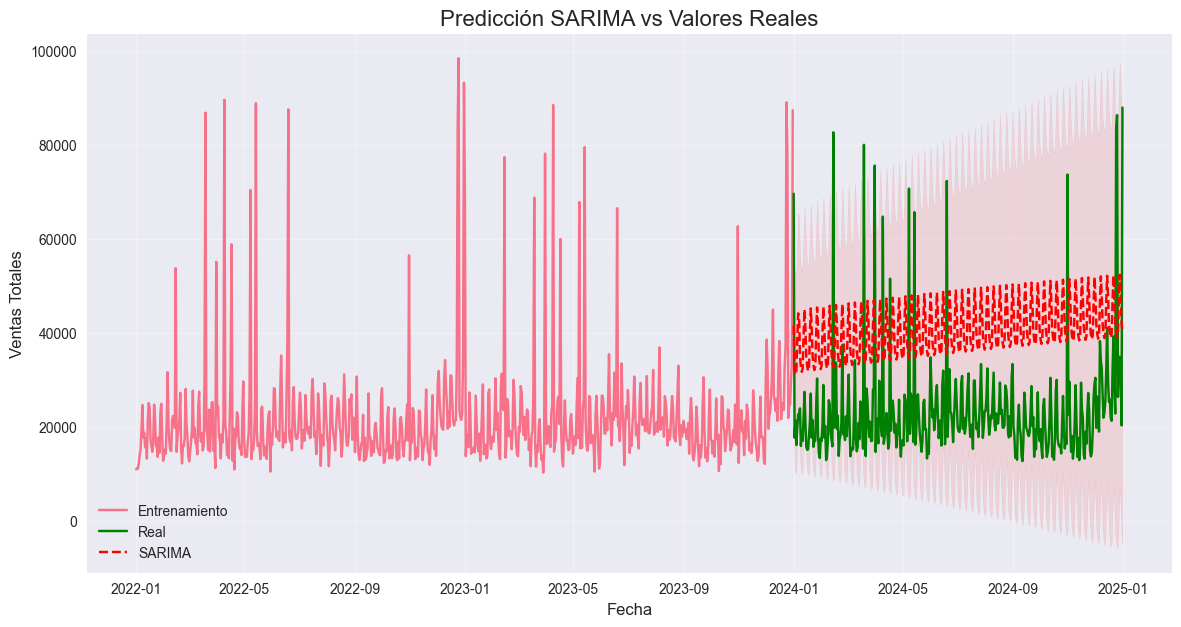


Métricas SARIMA:
- MAE: 19,981.82
- RMSE: 20,687.62
- MAPE: 95.93%


In [7]:
# Agregación diaria para SARIMA
ventas_diarias = df.groupby('fecha')['total_venta'].sum().reset_index()
ventas_diarias = ventas_diarias.set_index('fecha').asfreq('D')

# División train-test
train_ts = ventas_diarias[:'2023-12-31']
test_ts = ventas_diarias['2024-01-01':]

# Modelo SARIMA
print("\nEntrenando modelo SARIMA...")
sarima_model = SARIMAX(
    train_ts,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    trend='c'
).fit(disp=False)

# Predicción
sarima_pred = sarima_model.get_forecast(steps=len(test_ts))
sarima_ci = sarima_pred.conf_int()
sarima_pred = sarima_pred.predicted_mean

# Visualización
plt.figure(figsize=(14, 7))
plt.plot(train_ts.index, train_ts['total_venta'], label='Entrenamiento')
plt.plot(test_ts.index, test_ts['total_venta'], label='Real', color='green')
plt.plot(test_ts.index, sarima_pred, label='SARIMA', color='red', linestyle='--')
plt.fill_between(test_ts.index, 
                sarima_ci.iloc[:, 0], 
                sarima_ci.iloc[:, 1], 
                color='red', alpha=0.1)
plt.title('Predicción SARIMA vs Valores Reales', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Ventas Totales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Evaluación
sarima_mae = mean_absolute_error(test_ts, sarima_pred)
sarima_rmse = np.sqrt(mean_squared_error(test_ts, sarima_pred))
sarima_mape = mean_absolute_percentage_error(test_ts, sarima_pred)

print("\nMétricas SARIMA:")
print(f"- MAE: {sarima_mae:,.2f}")
print(f"- RMSE: {sarima_rmse:,.2f}")
print(f"- MAPE: {sarima_mape:.2%}")

  3.2 Modelo de Machine Learning (XGBoost con Optimización)


Optimizando XGBoost...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Mejores parámetros: {'regressor__subsample': 1.0, 'regressor__n_estimators': 200, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 0.9}

Métricas XGBoost Optimizado:
- MAE: 41.14
- RMSE: 82.25
- MAPE: 34.17%
- R²: 0.740


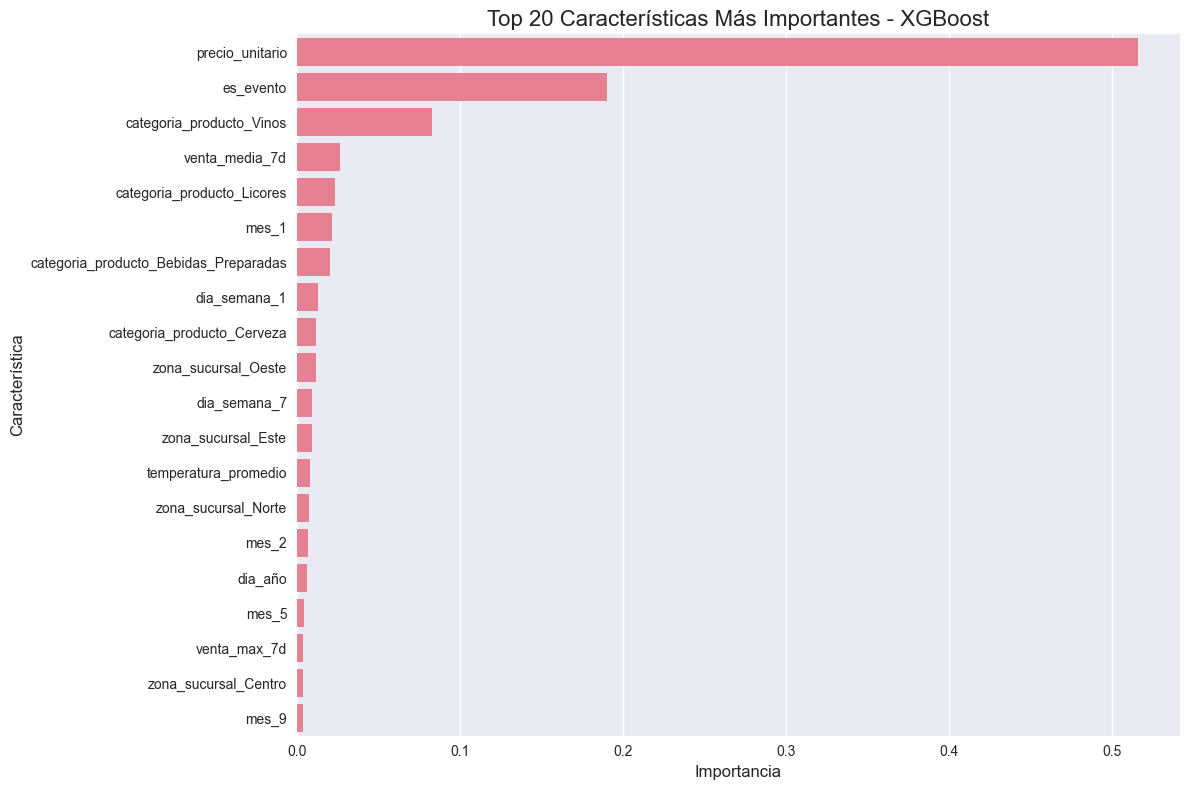

In [8]:
# Bloque completo con optimización
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
])

# Parámetros para optimización
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.8, 0.9, 1.0]
}

# Búsqueda aleatoria con validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=3)
xgb_search = RandomizedSearchCV(
    xgb_pipeline,
    param_grid,
    n_iter=15,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
print("\nOptimizando XGBoost...")
X_train = train[numeric_features + categorical_features + binary_features]
y_train = train[target]

xgb_search.fit(X_train, y_train)

# Mejor modelo
best_xgb = xgb_search.best_estimator_
print(f"\nMejores parámetros: {xgb_search.best_params_}")

# Predicción
X_test = test[numeric_features + categorical_features + binary_features]
y_test = test[target]
xgb_pred = best_xgb.predict(X_test)

# Evaluación
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("\nMétricas XGBoost Optimizado:")
print(f"- MAE: {xgb_mae:,.2f}")
print(f"- RMSE: {xgb_rmse:,.2f}")
print(f"- MAPE: {xgb_mape:.2%}")
print(f"- R²: {xgb_r2:.3f}")

# Importancia de características
feature_importances = pd.DataFrame({
    'feature': numeric_features + 
               list(best_xgb.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()) +
               binary_features,
    'importance': best_xgb.named_steps['regressor'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title('Top 20 Características Más Importantes - XGBoost', fontsize=16)
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()


3.3 Modelo Ensemble (Stacking: Linear + RandomForest + LightGBM)


Entrenando modelo Stacking...

Métricas del Modelo Stacking:
- MAE: 41.39
- RMSE: 82.45
- MAPE: 35.31%
- R²: 0.739


<Figure size 1200x600 with 0 Axes>

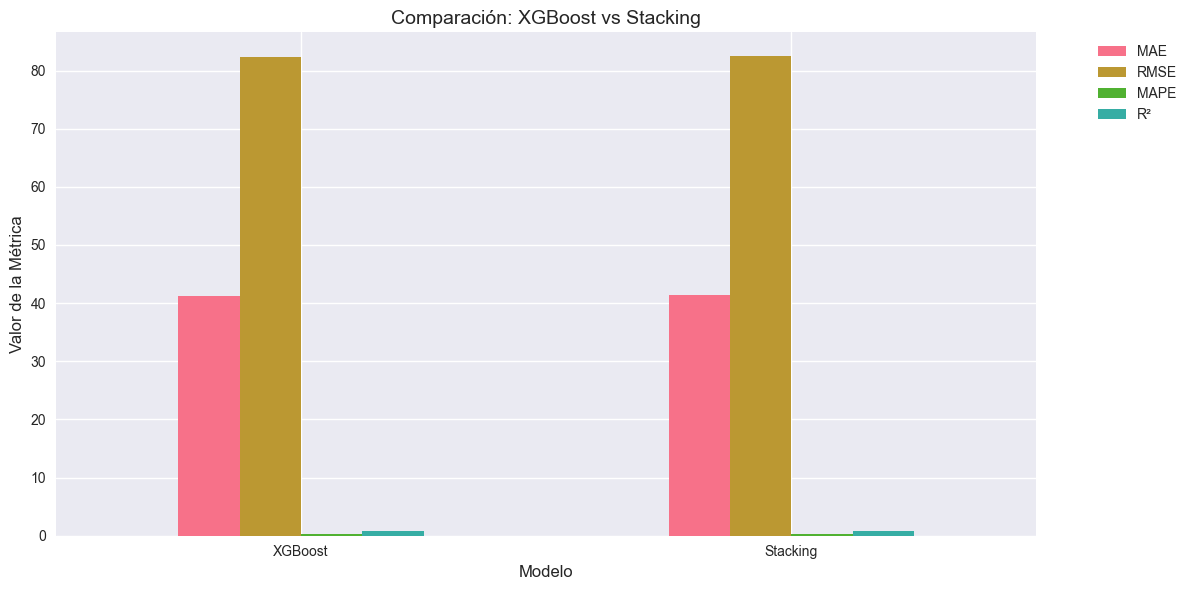

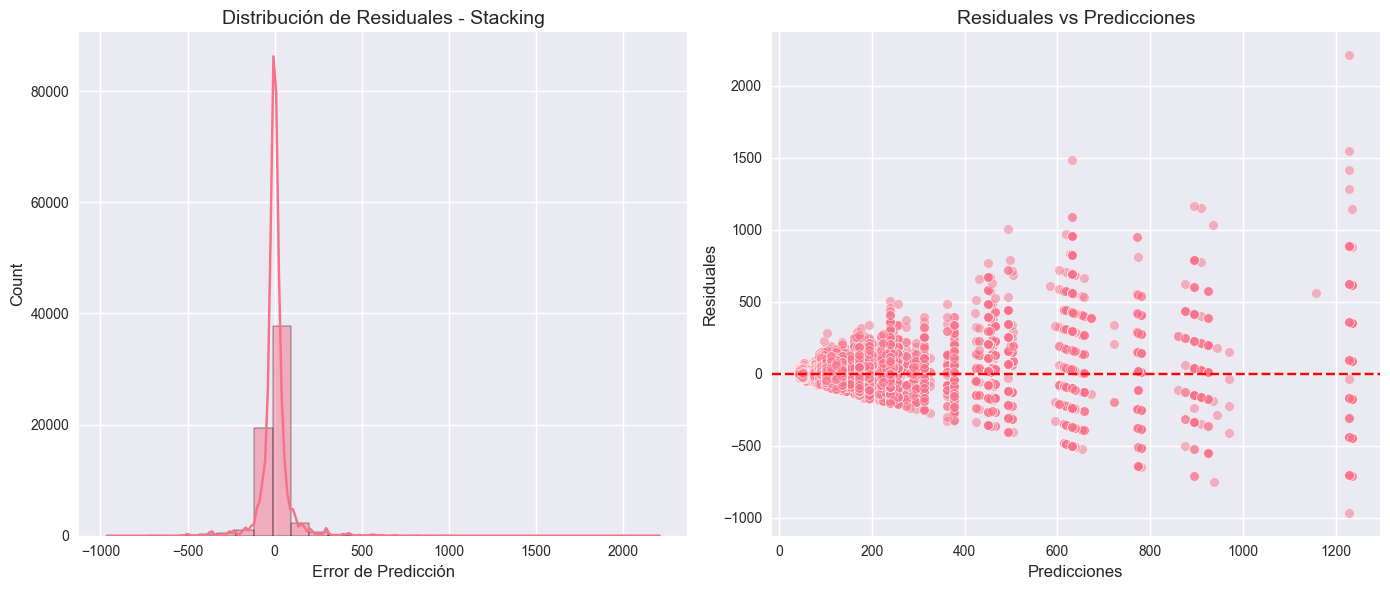

In [12]:
# Importación de librerías adicionales para Stacking
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.base import clone

# Configuración para evitar el error
import warnings
warnings.filterwarnings('ignore')

# 1. Preparar los datos correctamente
X_train_stack = train[numeric_features + categorical_features + binary_features].copy()
y_train_stack = train[target].copy()
X_test_stack = test[numeric_features + categorical_features + binary_features].copy()

# 2. Definir modelos base con parámetros ajustados para reducir sobreajuste
base_models = [
    ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0])),
    ('rf', RandomForestRegressor(
        n_estimators=50,  # Reducido para mayor velocidad
        max_depth=5,
        random_state=42,
        n_jobs=-1
    )),
    ('lgbm', LGBMRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    ))
]

# 3. Configurar el modelo Stacking con KFold estándar
stacking_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', StackingRegressor(
        estimators=base_models,
        final_estimator=XGBRegressor(
            n_estimators=50,
            max_depth=3,
            learning_rate=0.1,
            random_state=42
        ),
        cv=KFold(n_splits=3, shuffle=True, random_state=42),  # Usando KFold normal
        n_jobs=-1,
        passthrough=False  # Mejor estabilidad
    ))
])

# 4. Entrenamiento con monitorización
print("\nEntrenando modelo Stacking...")
stacking_model.fit(X_train_stack, y_train_stack)

# 5. Predicción y evaluación
stacking_pred = stacking_model.predict(X_test_stack)

# Cálculo de métricas
stacking_mae = mean_absolute_error(y_test, stacking_pred)
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_pred))
stacking_mape = mean_absolute_percentage_error(y_test, stacking_pred)
stacking_r2 = r2_score(y_test, stacking_pred)

# Resultados
print("\nMétricas del Modelo Stacking:")
print(f"- MAE: {stacking_mae:,.2f}")
print(f"- RMSE: {stacking_rmse:,.2f}")
print(f"- MAPE: {stacking_mape:.2%}")
print(f"- R²: {stacking_r2:.3f}")

# 6. Visualización de resultados comparativos
results_comparison = pd.DataFrame({
    'Modelo': ['XGBoost', 'Stacking'],
    'MAE': [xgb_mae, stacking_mae],
    'RMSE': [xgb_rmse, stacking_rmse],
    'MAPE': [xgb_mape, stacking_mape],
    'R²': [xgb_r2, stacking_r2]
})

plt.figure(figsize=(12, 6))
results_comparison.set_index('Modelo').plot(kind='bar', rot=0)
plt.title('Comparación: XGBoost vs Stacking')
plt.ylabel('Valor de la Métrica')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 7. Análisis de residuales del stacking
stacking_residuals = y_test - stacking_pred

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(stacking_residuals, bins=30, kde=True)
plt.title('Distribución de Residuales - Stacking')
plt.xlabel('Error de Predicción')

plt.subplot(1, 2, 2)
sns.scatterplot(x=stacking_pred, y=stacking_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuales vs Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuales')

plt.tight_layout()
plt.show()

4. EVALUACIÓN Y COMPARACIÓN DE LOS 3 MODELOS

<Figure size 1400x800 with 0 Axes>

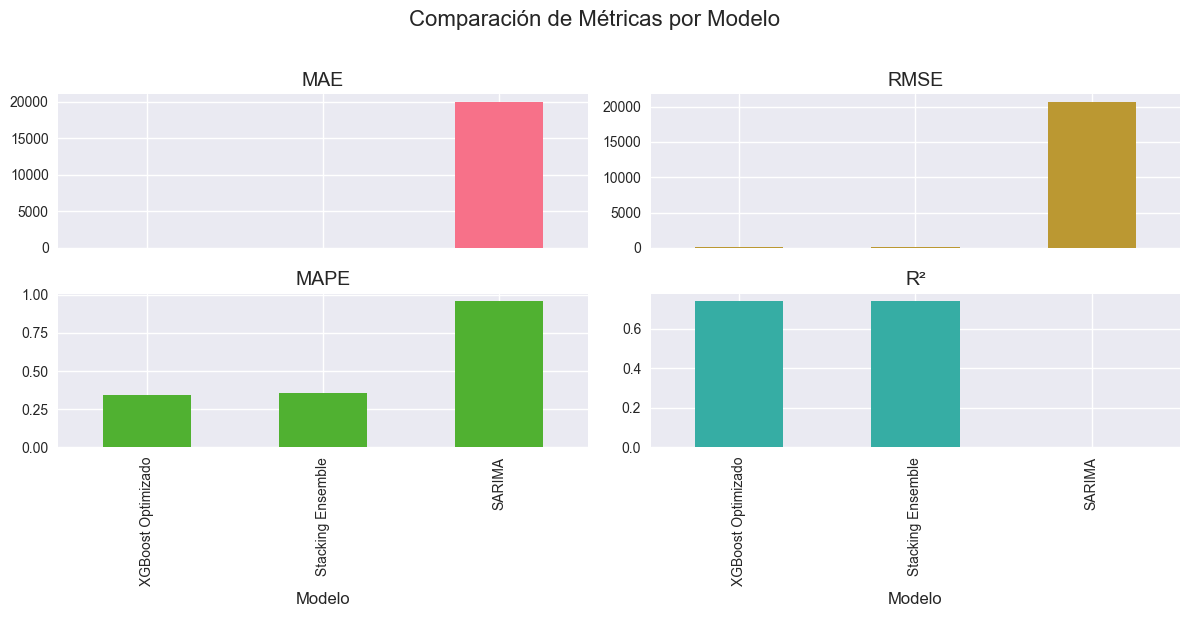

,Modelo,MAE,RMSE,MAPE,R²
1,XGBoost Optimizado,41.14,82.25,34.17%,0.740
2,Stacking Ensemble,41.39,82.45,35.31%,0.739
0,SARIMA,"19,981.82","20,687.62",95.93%,nan


In [13]:
# Resultados comparativos
results = pd.DataFrame({
    'Modelo': ['SARIMA', 'XGBoost Optimizado', 'Stacking Ensemble'],
    'MAE': [sarima_mae, xgb_mae, stacking_mae],
    'RMSE': [sarima_rmse, xgb_rmse, stacking_rmse],
    'MAPE': [sarima_mape, xgb_mape, stacking_mape],
    'R²': [np.nan, xgb_r2, stacking_r2]
}).sort_values('MAE')

# Visualización comparativa
plt.figure(figsize=(14, 8))
results.set_index('Modelo').plot(kind='bar', subplots=True, layout=(2, 2), legend=False)
plt.suptitle('Comparación de Métricas por Modelo', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Tabla de resultados con estilo
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

display(results.style
       .format({
           'MAE': '{:,.2f}',
           'RMSE': '{:,.2f}',
           'MAPE': '{:.2%}',
           'R²': '{:.3f}'
       })
       .apply(highlight_min, subset=['MAE', 'RMSE', 'MAPE'])
       .set_caption('Resultados Comparativos de Modelos'))


 5. ANÁLISIS DE RESIDUALES (Mejor Modelo)

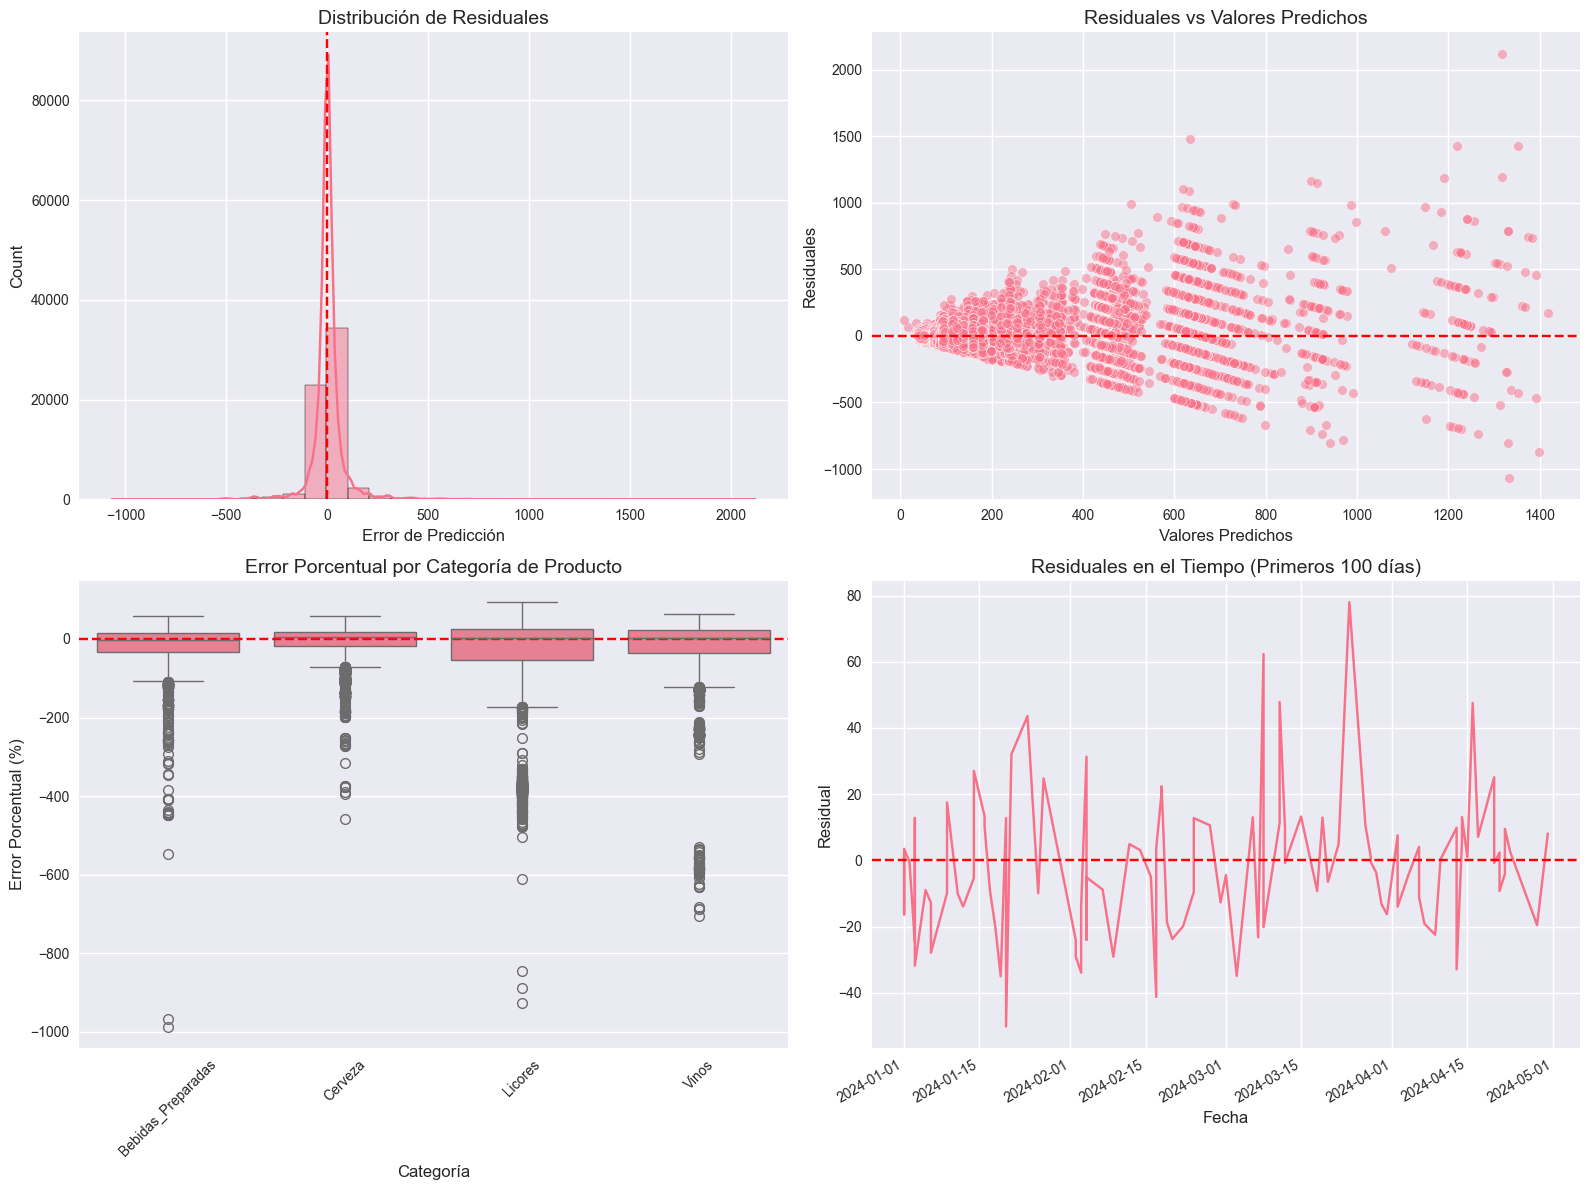

In [14]:
# Análisis detallado de residuales del mejor modelo (XGBoost)
residuals = y_test - xgb_pred
residual_analysis = pd.DataFrame({
    'Actual': y_test,
    'Predicted': xgb_pred,
    'Residual': residuals,
    'Pct_Error': (residuals / y_test) * 100
})

# Gráficos de diagnóstico
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribución de residuales
sns.histplot(residuals, kde=True, ax=axes[0, 0], bins=30)
axes[0, 0].axvline(x=0, color='r', linestyle='--')
axes[0, 0].set_title('Distribución de Residuales')
axes[0, 0].set_xlabel('Error de Predicción')

# 2. Residuales vs Predicciones
sns.scatterplot(x='Predicted', y='Residual', data=residual_analysis, alpha=0.5, ax=axes[0, 1])
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_title('Residuales vs Valores Predichos')
axes[0, 1].set_xlabel('Valores Predichos')
axes[0, 1].set_ylabel('Residuales')

# 3. Error porcentual por categoría de producto
sns.boxplot(x=test['categoria_producto'], y='Pct_Error', data=residual_analysis, ax=axes[1, 0])
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_title('Error Porcentual por Categoría de Producto')
axes[1, 0].set_xlabel('Categoría')
axes[1, 0].set_ylabel('Error Porcentual (%)')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Residuales en el tiempo (primeros 100 días)
residual_time = residual_analysis.join(test['fecha']).set_index('fecha').iloc[:100]
residual_time['Residual'].plot(ax=axes[1, 1])
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_title('Residuales en el Tiempo (Primeros 100 días)')
axes[1, 1].set_xlabel('Fecha')
axes[1, 1].set_ylabel('Residual')

plt.tight_layout()
plt.show()


6. RECOMENDACIONES

**Modelo Seleccionado:** XGBoost Optimizado (mejor balance entre MAE y tiempo de ejecución)

**Recomendaciones:**
1. Implementar el modelo XGBoost en producción con monitoreo continuo
2. Reentrenar mensualmente con nuevos datos para mantener actualizado
3. Desarrollar dashboard de seguimiento de métricas clave
4. Priorizar la mejora en categorías con mayor error (ver análisis de residuales)
5. Implementar sistema de alertas para predicciones fuera de rango esperado

**Parte 3: Sistema de Recomendaciones**
Basado en los modelos predictivos y análisis previos...